In [1]:
# Initial setup of emulation of simulation
# Using probabilistic model: openTURNS marginals+copula
#
# Author: Alex Braafladt
#
# Version: v1 Initial creation 4/29/2022
#
# References:
#   -https://openturns.github.io/openturns/latest/theory/probabilistic_modeling/copulas.html#copula
#   -https://en.wikipedia.org/wiki/Copula_(probability_theory)

In [2]:
# probabilistic modeling framework
import openturns as ot
import openturns.viewer as viewer

# numerical computing
import numpy as np
import pandas as pd

# graphing and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistical tools
from scipy.stats import pearsonr

# Goal: Emulate data from agent-based simulation
Agent-based simulation is used in a variety of fields to model complex systems using an agent-focused perspective. This can be individual drivers or vehicles, individual aircraft or other systems, individual people, or any entity with  important to the decision-making problem.

#### A few examples:
-[Transportation](https://www.sciencedirect.com/science/article/pii/S0965856420306133)
-[Unmanned air traffic management](https://arc.aiaa.org/doi/10.2514/6.2021-0812)
-[Military operations](https://csiac.org/wp-content/uploads/2021/06/CSIAC_Journal_V7N3_smaller_file_size2.pdf#page=50)
-[Robot swarms](https://ieeexplore.ieee.org/document/9340854)
-[Road traffic](https://github.com/flow-project/flow/blob/master/tutorials/tutorial01_sumo.ipynb)

#### Analysis using agent-based simulation

These simulations utilize stochastic inputs as a part of the specification of the model of the environment and the agents. This results in stochastic outputs from the simulation. Typically, only the mean values of these outputs are considered (for example [in a case looking at military operations](https://arc.aiaa.org/doi/10.2514/6.2020-1127)). However, current research is working on enabling the use of additional information about the stochastic distributions in the analysis tasks ([for design space divergence](https://smartech.gatech.edu/bitstream/handle/1853/56241/KIM-DISSERTATION-2016.pdf), [visual analytics](https://smartech.gatech.edu/handle/1853/60220), and [more](https://calhoun.nps.edu/handle/10945/57853?show=full)).

The distributions are characterized by continuous and discrete variables and non-normal and multi-modal shapes. A few examples of what these can look like:

![](./resources/distribution1.png)
[1](https://apps.dtic.mil/sti/pdfs/ADA621426.pdf)

![](./resources/distribution2.png)
[2](https://smartech.gatech.edu/handle/1853/64805)

Working with these distributions is a major challenge in the analysis process using operational simulation. The experiment in this repository looks specifically at working with predictive models ("surrogate models") of multiple distributions generated in simulation to support the types of analysis tasks described above.

To develop an approach for predictive modeling with these distributions, a generative, probabilistic model is used as an proof-of-concept emulation that matches the characteristics of the type of data expected with agent-based simulation.

# Joint Distributions Using Copulas
The generative models used in this work are based on individually defining marginal distributions and connecting those marginals using a Gaussian copula. This allows working directly with marginal distributions like those from simulation and with correlations between marginals like the correlations between outputs in simulation.

See additional resources for background on copulas ([openTURNS](https://openturns.github.io/openturns/1.11/examples/probabilistic_modeling/composed_distribution.html), [wikipedia](https://en.wikipedia.org/wiki/Copula_(probability_theory)), [Data to AI Lab at MIT](https://sdv.dev/Copulas/tutorials/01_Introduction_to_Copulas.html), [Tensoflow](https://www.tensorflow.org/probability/examples/Gaussian_Copula)).


In [3]:
# a simple marginal+copula joint distribution example

# set up the marginal distributions
dist1 = ot.Binomial(20, 0.5)
dist2 = ot.Skellam(2.7, 10.)
dist3 = ot.Normal(0.0,1.0)
mdistributions = [ot.Skellam(10, 5), ot.Skellam(30,10)]
mweights = [0.5, 0.5]
dist4 = ot.Mixture(mdistributions, mweights)

marginals = [dist1, dist2, dist3, dist4]
distribution = ot.ComposedDistribution(marginals)

R = ot.CorrelationMatrix(4)
R[0, 1] = 0.3
R[0, 2] = 0.6
R[2, 3] = 0.5
R[0, 3] = 0.5
R[1,3] = 0.4
R[1,2] = 0.1
copula = ot.NormalCopula(R)

In [4]:
jointDistribution = ot.ComposedDistribution(marginals, copula)

In [5]:
samples = jointDistribution.getSample(1000)
samples_df = pd.DataFrame(np.array(samples), columns=['Binomial', 'Skellam', 'Normal', 'SkellamMix'])

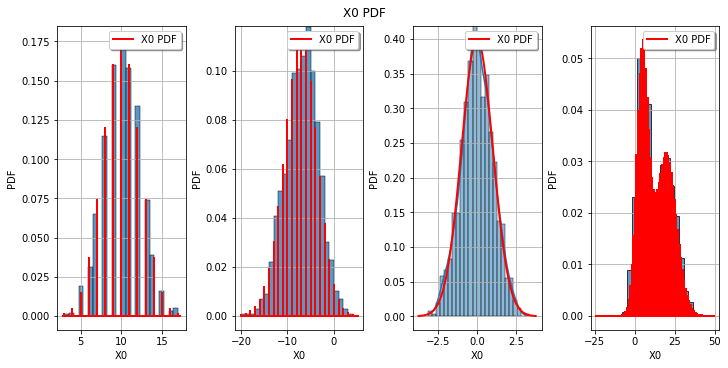

In [7]:
# plot marginal samples and true pdfs
fig1, ax1 = plt.subplots(1, 4, figsize=(10,5), constrained_layout=True)
sns.histplot(data=samples_df["Binomial"], ax = ax1[0], stat='probability')
sns.histplot(data=samples_df["Skellam"], ax = ax1[1], stat='probability')
sns.histplot(data=samples_df["Normal"], ax = ax1[2], kde=True, stat='density')
sns.histplot(data=samples_df["SkellamMix"], ax = ax1[3], stat='density')
margpdf1 = dist1.drawPDF()
margpdf2 = dist2.drawPDF()
margpdf3 = dist3.drawPDF()
margpdf4 = dist4.drawPDF()
ax_s1 = ax1[0:]
ax_s2 = ax1[1:]
ax_s3 = ax1[2:]
ax_s4 = ax1[3:]
mpdf1 = ot.viewer.View(margpdf1,axes=ax_s1)
mpdf2 = ot.viewer.View(margpdf2,axes=ax_s2)
mpdf3 = ot.viewer.View(margpdf3,axes=ax_s3)
mpdf4 = ot.viewer.View(margpdf4,axes=ax_s4)

In [8]:
# test the correlations between the sampled values of the marginal distributions

for column in samples_df.columns:
    for col in samples_df.columns:
        # indep_test = multiscale_graphcorr(sample_df[col].to_numpy(),sample_df[column].to_numpy(),is_twosamp=True)
        indep_test = pearsonr(samples_df[col].to_numpy(),samples_df[column].to_numpy())
        #
        print('Sample ',col, ' compared to ', column, 'stat: %.3f, pval: %.3f' % (indep_test[0], indep_test[1]))

Sample  Binomial  compared to  Binomial stat: 1.000, pval: 0.000
Sample  Skellam  compared to  Binomial stat: 0.302, pval: 0.000
Sample  Normal  compared to  Binomial stat: 0.604, pval: 0.000
Sample  SkellamMix  compared to  Binomial stat: 0.499, pval: 0.000
Sample  Binomial  compared to  Skellam stat: 0.302, pval: 0.000
Sample  Skellam  compared to  Skellam stat: 1.000, pval: 0.000
Sample  Normal  compared to  Skellam stat: 0.133, pval: 0.000
Sample  SkellamMix  compared to  Skellam stat: 0.385, pval: 0.000
Sample  Binomial  compared to  Normal stat: 0.604, pval: 0.000
Sample  Skellam  compared to  Normal stat: 0.133, pval: 0.000
Sample  Normal  compared to  Normal stat: 1.000, pval: 0.000
Sample  SkellamMix  compared to  Normal stat: 0.484, pval: 0.000
Sample  Binomial  compared to  SkellamMix stat: 0.499, pval: 0.000
Sample  Skellam  compared to  SkellamMix stat: 0.385, pval: 0.000
Sample  Normal  compared to  SkellamMix stat: 0.484, pval: 0.000
Sample  SkellamMix  compared to  Skel